In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

 92% 91.0M/98.7M [00:01<00:00, 78.4MB/s]
100% 98.7M/98.7M [00:01<00:00, 90.0MB/s]


In [ ]:
!unzip /content/melanoma-skin-cancer-dataset-of-10000-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: melanoma_cancer_dataset/train/benign/melanoma_643.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_644.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_645.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_646.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_647.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_648.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_649.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_65.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_650.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_651.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_652.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_653.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_654.jpg  
  inflating: melanoma_cancer_dataset/train/benign/mel

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
print(tf.__version__)

2.12.0


In [ ]:
# Create a list with the filepaths for training and testing
train_dir = Path('/content/melanoma_cancer_dataset/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg')) #membaca gambar .jpg

In [ ]:
test_dir = Path('/content/melanoma_cancer_dataset/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [ ]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [ ]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)

In [ ]:
print("shape x Train", train_df.shape)

shape x Train (9605, 2)


In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 9605

Number of different labels: 2

Labels: ['benign' 'malignant']


In [ ]:
train_df.head(5)

,Filepath,Label
0,/content/melanoma_cancer_dataset/train/benign/...,benign
1,/content/melanoma_cancer_dataset/train/benign/...,benign
2,/content/melanoma_cancer_dataset/train/maligna...,malignant
3,/content/melanoma_cancer_dataset/train/maligna...,malignant
4,/content/melanoma_cancer_dataset/train/maligna...,malignant


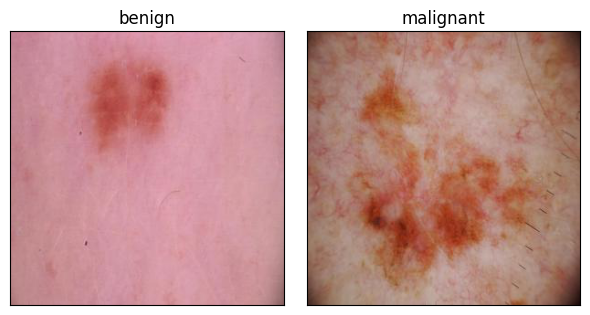

In [ ]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(df_unique):
        ax.imshow(plt.imread(df_unique["Filepath"][i]))
        ax.set_title(df_unique["Label"][i], fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:

image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                fill_mode="nearest",
                                                                zoom_range=0.15,
                                                                horizontal_flip=True, validation_split=0.2)

In [ ]:


train_images = image_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(170, 170),
    color_mode='rgb',
    shuffle = True,
    class_mode='categorical',
    batch_size=54
)



Found 9605 validated image filenames belonging to 2 classes.


In [ ]:
test_images = image_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(170, 170),
    color_mode='rgb',
    shuffle = True,
    class_mode='categorical',
    batch_size=54
)

Found 9605 validated image filenames belonging to 2 classes.


In [ ]:
pretrained_model = tf.keras.applications.densenet.DenseNet121(
    input_shape=(170, 170, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)


outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="Adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=test_images,
    epochs= 50,
    #  callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=2,
    #         restore_best_weights=True
    #     )
    # ]

)

Epoch 1/50
178/178 [==============================] - 186s 953ms/step - loss: 0.3389 - accuracy: 0.8510 - val_loss: 0.2951 - val_accuracy: 0.8707
Epoch 2/50
178/178 [==============================] - 162s 911ms/step - loss: 0.2828 - accuracy: 0.8786 - val_loss: 0.2557 - val_accuracy: 0.8945
Epoch 3/50
178/178 [==============================] - 161s 906ms/step - loss: 0.2619 - accuracy: 0.8917 - val_loss: 0.2426 - val_accuracy: 0.8986
Epoch 4/50
178/178 [==============================] - 161s 909ms/step - loss: 0.2530 - accuracy: 0.8945 - val_loss: 0.2300 - val_accuracy: 0.9052
Epoch 5/50
178/178 [==============================] - 159s 893ms/step - loss: 0.2378 - accuracy: 0.9027 - val_loss: 0.2312 - val_accuracy: 0.9085
Epoch 6/50
178/178 [==============================] - 158s 892ms/step - loss: 0.2337 - accuracy: 0.9056 - val_loss: 0.2278 - val_accuracy: 0.9046
Epoch 7/50
178/178 [==============================] - 162s 912ms/step - loss: 0.2287 - accuracy: 0.9062 - val_loss: 0.2251 -

178/178 [==============================] - 79s 440ms/step - loss: 0.1497 - accuracy: 0.9385


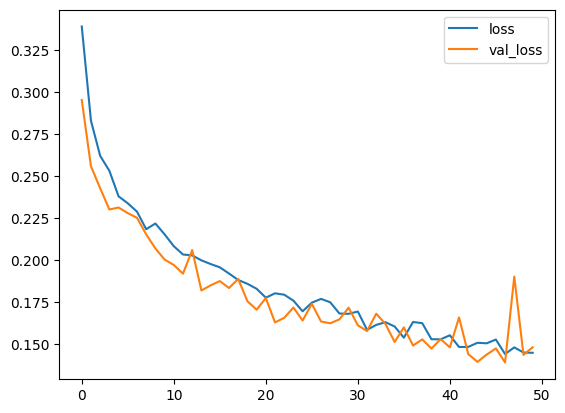

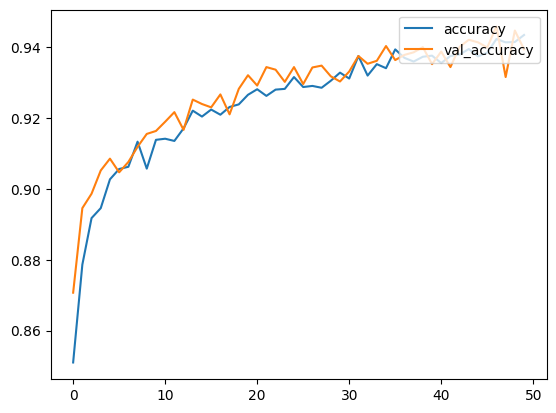

In [ ]:
model.evaluate(test_images)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

178/178 [==============================] - 89s 491ms/step


['malignant',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'malignant',
 'benign',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'm

In [ ]:
def output(location):
    img=load_img(location,target_size=(170, 170,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [ ]:
img = output('/content/melanoma_cancer_dataset/test/benign/melanoma_10004.jpg')
img

1/1 [==============================] - 0s 143ms/step


'benign'

In [ ]:
model.save_weights('model121_1.h5')

Saving melanoma_10154.jpg to melanoma_10154.jpg
1/1 [==============================] - 0s 29ms/step
[0.01293706 0.987063  ]
melanoma_10154.jpg adalah malignant


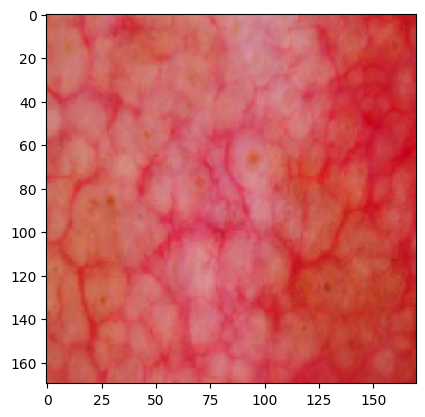

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image
import keras.utils as image
uploaded = files.upload()

for fn in uploaded.keys():
  # Load the image
  path = '/content/' + fn
  img = image.load_img(path, target_size=(170, 170))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  
  # Preprocess the image
  x = np.expand_dims(x, axis=0)
  x = x/255.  # Normalize the image
  
  # Predict the class
  classes = model.predict(x, batch_size=10)
  print(classes[0])
  
  # Map the class probabilities to class labels
  class_labels = ['benign', 'malignant']
  predicted_class_index = np.argmax(classes[0])
  predicted_class_label = class_labels[predicted_class_index]
  
  # Print the result
  print(fn + " adalah " + predicted_class_label)